### Load the required libraries

In [2]:
import neural_process as nep
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

For a given task $\mathcal{T}$, generate the dataset $X^{(t)}, Y^{(t)}$ of all inputs and output, respectively. During meta-training, we will split it randomly in training data $D^{(t)} = \left\{\left(x_i^{(t)}, y_i^{(t)}\right)\right\}_{i=1}^{N_t}$ and test data $\left\{\left(\tilde{x}_i^{(t)}, \tilde{y}_i^{(t)}\right)\right\}_{i=1}^{M_t}$. I will skip the $t$ henceforth since we take into consideration one task. 

We will consider $X$ and $Y$ to be 400-dimesional vectors. For each $x_i \in X$, $y_i = \text{sin}(x_i)$

Sizes
  x: (80, 1) 
  y: (80, 1)


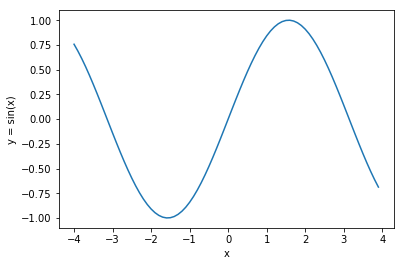

In [3]:
x_all = np.arange(-4, 4, 0.1).reshape(-1, 1).astype(np.float32)
y_all = np.sin(x_all)

print('Sizes\n', ' x:', x_all.shape, '\n  y:', y_all.shape)
plt.plot(x_all, y_all)
plt.ylabel('y = sin(x)')
plt.xlabel('x')
plt.show()

In [3]:
a = torch.distributions.Normal(0,1)
a.sample((1,))

tensor([-0.2934])

-----

## The model

We will specify the number of units and the activation function for each layer in a list of tuples, one tuple per layer. 
> e.g. `[(5, torch.nn.ReLU()), (3, None)]` for a 2-layer neural network, with 5-unit relu-activated hidden layer and a 3-unit linear output layer (no activations).

In [4]:
r_dim = 8
z_dim = 10
h_specs = [(5, torch.nn.ReLU()), (10, torch.nn.ReLU()), (5, torch.nn.ReLU()), (r_dim, None)]
g_specs = [(5, torch.nn.ReLU()), (10, torch.nn.ReLU()), (x_all.shape[1], None)]
h_input_dim = x_all.shape[1] + y_all.shape[1]
g_input_dim = x_all.shape[1] + z_dim

In [5]:
h = nep.Encoder(h_input_dim, h_specs, )
r_to_z = nep.Zparams(r_dim, z_dim)
g = nep.Decoder(g_input_dim, g_specs)

Let's see how the model, untrained, behaves. That is we will generate 50 samples from $z \sim \mathcal{N}\left(0, I_{\texttt{z_dim}}\right)$

In [6]:
x_all_tensor = torch.from_numpy(x_all)
z = torch.distributions.Normal(0, 1)
z_sample = z.sample((50, z_dim))

Create the 50 matrices to use as inputs of the 50 forward passes in the decoder, e.g. *one* input matrix has the form
\begin{bmatrix}
    x_{1} & z_{1} & \cdots & z_{\text{z_dim}} \\
    \vdots & \vdots & \vdots \\
    x_{N+M} & z_{1} & \cdots & z_{\text{z_dim}} \\
\end{bmatrix}

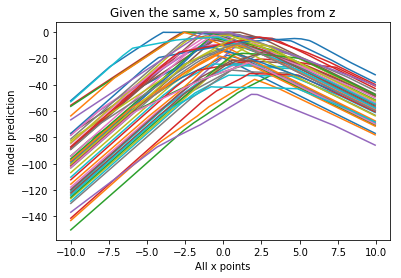

In [7]:
# create the 50 matrices
z_s = z_sample.unsqueeze(-1).expand(z_sample.shape[0], z_sample.shape[1], x_all_tensor.shape[0]).transpose(1,2)
x_s = x_all_tensor.unsqueeze(0).expand(z_sample.shape[0], x_all_tensor.shape[0], x_all_tensor.shape[1])
xz = torch.cat([x_s, z_s], dim=2)

# plt.plot(x_all_tensor.data.numpy(), np.sin(x_all_tensor.data.numpy()))
for i in range(xz.shape[0]):
    y_hat_mean, _ = g(xz[i])
    plt.plot(x_all_tensor.data.numpy(), y_hat_mean.data.numpy())
plt.title('Given the same x, 50 samples from z')
plt.xlabel('All x points')
plt.ylabel('model prediction')
plt.show()

## Training

To meta-train the algorithm we will, at each `epoch`:

1. Randomly split the dataset into training $D = \left\{\left(x_i, y_i\right)\right\}_{i=1}^{N}$ and test set $\left\{\left(\tilde{x}_i, \tilde{y}_i\right)\right\}_{i=1}^{M}$ (also the respective dimesions are random, i.e. `n_context` is selected randomly)
2. Forward pass in the encoder to map training data $D$ to $\left(\mu_z, \log\sigma_z^2\right)$ of $z$
3. Forward pass in the encoder to map **all** data to $\left(\mu_{z_{all}}, \log\sigma_{z_{all}}^2\right)$ of $z_{all}$
4. Compute the KL divergence between this two distributions
5. Using as inputs $z_{all}$ and the $\tilde{x_i}$, make a forward pass in the decoder to compute $\left(\mu, \sigma\right)$ of the distribution of the $\tilde{y}$'s
6. Once we have the distribution of the $\tilde{y}$'s, plug in the value of $\tilde{y}_i$ corresponding to the $\tilde{x}_i$ used and compute the log-likelihood
7. Minimize the negative log-likelihood and the KL divergence jointly


-----

In [1]:
import neural_process as nep
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
x_np = np.arange(-4, 4, 0.1).reshape(-1, 1).astype(np.float32)
y_np = np.sin(x_np)
x_np.shape

(80, 1)

In [3]:
r_dim = 2
z_dim = 2
h_specs = [(8, torch.nn.ReLU()), (r_dim, None)]
g_specs = [(8, torch.nn.ReLU()), (y_np.shape[1], None)]
h_input_dim = x_np.shape[1] + y_np.shape[1]
g_input_dim = x_np.shape[1] + z_dim

In [4]:
h = nep.Encoder(h_input_dim, h_specs, )
r_to_z = nep.Zparams(r_dim, z_dim)
g = nep.Decoder(g_input_dim, g_specs)

In [14]:
optimizer = torch.optim.Adam(params=list(g.parameters()) + list(h.parameters()) + list(r_to_z.parameters()), lr=0.001)
epochs = 1000
losses = []
kl = []
nll = []

for epoch in range(epochs):
    optimizer.zero_grad()
    n_context = np.random.choice(range(1, x_np.shape[0]))
    x_c, y_c, x_t, y_t = nep.randsplit_totensor(x_np, y_np, n_context)
    x_all = torch.from_numpy(x_np)
    y_all = torch.from_numpy(y_np)

    xy_all = torch.cat([x_all, y_all], dim=1)
    z_mean_all, z_logvar_all = r_to_z(h(xy_all))
    z_std_all = torch.exp(0.5 * z_logvar_all)
    z_sample_all = nep.sample_z(z_mean_all, z_logvar_all, how_many=1)
    #xz_all = torch.cat([x_c, z_sample_c.expand(x_c.shape[0], -1)], dim=1)

    xy_c = torch.cat([x_c, y_c], dim=1)
    z_mean_c, z_logvar_c = r_to_z(h(xy_c))
    z_std_c = torch.exp(0.5 * z_logvar_c)
    z_sample_c = nep.sample_z(z_mean_c, z_logvar_c, how_many=1)
    xz_t = torch.cat([x_t, z_sample_c.expand(x_t.shape[0], -1)], dim=1)

    mean, logvar = g(xz_t)
    std = torch.exp(0.5 * logvar)

    NLL = nep.neg_loglik(mean, std, y_t)
    KL = nep.KL_div(z_mean_c, z_std_c, z_mean_all, z_std_all)

    loss = NLL + KL
    losses.append(loss)
    kl.append(KL)
    nll.append(NLL)
    loss.backward()
    optimizer.step()



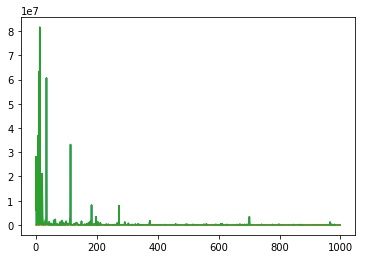

In [18]:
plt.plot(nll)
plt.plot(kl)
plt.plot(losses)
plt.show()

In [12]:
norm = torch.distributions.Normal(mean, std)
a = norm.log_prob(y_t).mean()
b = nep.neg_loglik(mean, std, y_t)
print(a,b)

tensor(-1025123072., grad_fn=<MeanBackward1>) tensor(1025123072., grad_fn=<NegBackward>)
